In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from google.colab import files
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # для стильных графиков
import numpy as np

from ipywidgets import interactive
from sklearn.metrics import pairwise_distances_argmin
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

data = pd.read_csv("Fashion_Retail_Sales.csv")
data.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
0,4018,Handbag,4619.0,2023-02-05,NaN,Credit Card
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash


Удалим повторяющиеся значения

In [3]:
data.drop_duplicates(inplace=True) # операция изменяет исходный DataFrame data, а не создает новый.
print(data.columns)

Index(['Customer Reference ID', 'Item Purchased', 'Purchase Amount (USD)',
       'Date Purchase', 'Review Rating', 'Payment Method'],
      dtype='object')


Поработаем с пропусками:

Когда работаем с категориальными данными в виде строк, используем моду. Для числовых данных медиана используется как стабильный показатель центрального значения без учета выбросов.

In [4]:
if data.isnull().any().any():
  print("Eсть пропуски в следующих столбцах: ", data.columns[data.isnull().any()].tolist())
  for column in data.columns:
      if data[column].isnull().sum() > len(data) / 2:
          data.drop(column, inplace=True)
          print(f"Столбец {column} удален, так как содержит более половины пропущенных значений.")
      else:
          if data[column].dtype == 'object':
              # Заполнение пропущенных значений в категориальных данных
              col_mode = data[column].mode()
              data[column] = data[column].fillna(col_mode)
              print(f"Все пропущенные значения столбца {column} заменены на наиболее частое значение {col_mode}, так как серия содержит менее половины пропущенных значений.")
          else:
              # Заполнение пропущенных значений в числовых данных
              col_median = data[column].median()
              data[column] = data[column].fillna(col_median)
              print(f"Все пропущенные значения столбца {column} заменены на медианное значение {col_median}, так как серия содержит менее половины пропущенных значений.")
else:
  print("Пропусков в данных нет :)")

Eсть пропуски в следующих столбцах:  ['Purchase Amount (USD)', 'Review Rating']
Все пропущенные значения столбца Customer Reference ID заменены на медианное значение 4040.0, так как серия содержит менее половины пропущенных значений.
Все пропущенные значения столбца Item Purchased заменены на наиболее частое значение 0    Belt
Name: Item Purchased, dtype: object, так как серия содержит менее половины пропущенных значений.
Все пропущенные значения столбца Purchase Amount (USD) заменены на медианное значение 110.0, так как серия содержит менее половины пропущенных значений.
Все пропущенные значения столбца Date Purchase заменены на наиболее частое значение 0    2023-09-22
Name: Date Purchase, dtype: object, так как серия содержит менее половины пропущенных значений.
Все пропущенные значения столбца Review Rating заменены на медианное значение 3.0, так как серия содержит менее половины пропущенных значений.
Все пропущенные значения столбца Payment Method заменены на наиболее частое значен

Выведем всю необходимую информацию о датафрейме для дальнейшего анализа и работы с категориальными переменными...

In [5]:
print(data.info(show_counts=True, memory_usage=False, verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Reference ID  3400 non-null   int64  
 1   Item Purchased         3400 non-null   object 
 2   Purchase Amount (USD)  3400 non-null   float64
 3   Date Purchase          3400 non-null   object 
 4   Review Rating          3400 non-null   float64
 5   Payment Method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)None


Таким образом, нечисловое значение данных предсталено в таких столбцах как:
*   Payment Method
*   Date Purchase
*   Item Purchased

Поработаем со столбцом Date Purchase, который содержит дату в виде: **год-месяц-день, но будучи типом string**.
Преобразуем столбец "Date Purchase" в формат даты и времени

In [6]:
df_copy = data.copy()

df_copy["Date Purchase"] = pd.to_datetime(df_copy["Date Purchase"], format="%Y-%m-%d")

Закодируем категориальные переменные с помощью LabelEncoder

In [7]:
lbl_en = LabelEncoder()
for column in ["Payment Method", "Item Purchased", "Customer Reference ID"]:
    df_copy[column] = lbl_en.fit_transform(data[column])
print(df_copy)
print(df_copy.dtypes)

      Customer Reference ID  Item Purchased  Purchase Amount (USD)  \
0                        61              13                 4619.0   
1                       158              46                 2456.0   
2                        62              42                 2102.0   
3                       140              20                 3126.0   
4                        40              49                 3003.0   
...                     ...             ...                    ...   
3395                    161              32                   37.0   
3396                     99              34                  176.0   
3397                     34              22                  110.0   
3398                     85              30                  128.0   
3399                     44               0                  115.0   

     Date Purchase  Review Rating  Payment Method  
0       2023-02-05            3.0               1  
1       2023-07-11            2.0               1  
2  

-----------------------------------------------------------------------------

Построим ⭐ **баланс классов** ⭐ для сравнения количества событий с меткой 0 и 1 в DataFrame

(возвращает подмножество строк, где булевая серия (True/False) = True (если значение в столбце "event" равно 0 ➡ True). Shape возвращает кортеж, состоящий из двух элементов (количество строк и количество столбцов), чтобы получить только количество строк, мы обращаемся к элементу с индексом 0 с помощью [0])

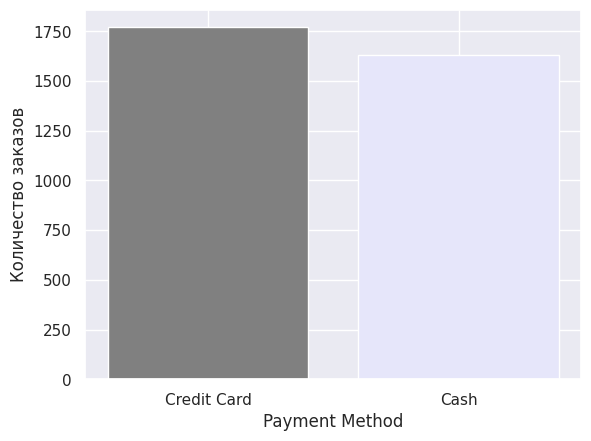

In [8]:
x = "Payment Method"
y1 = data[data[x] == "Credit Card"].shape[0]
y2 = data[data[x] == "Cash"].shape[0]

plt.bar(["Credit Card", "Cash"], [y1, y2], color=['grey', 'lavender'])
plt.xlabel("Payment Method")
plt.ylabel("Количество заказов")
plt.show()

__________________________________________________________________

Проведем расчет **RFM-анализа** для анализа поведения клиентов на основе трех ключевых метрик:

✅ 1.   *частоты покупок (Frequency)*

✅ 2.   *последней активности (Recency)*

✅ 3.   *платежеспособности (Monetary)*

Объединим все три метрики в общий DataFrame rfm_df путем слияния данных. Ключ 'Customer Reference ID'.В результате мы полумили информацию о частоте, последней активности и платежеспособности каждого клиента.

In [9]:
# частота покупок (Frequency)
frequency = df_copy.groupby('Customer Reference ID')['Item Purchased'].count() # группировка DataFrame df_copy по столбцу
                          #'Customer Reference ID' и подсчет количества уникальных значений в столбце 'Item Purchased'
frequency = frequency.reset_index() # сбрасываем индексы и преобразовываем результат в формат DataFrame

print(frequency)

     Customer Reference ID  Item Purchased
0                        0              14
1                        1              20
2                        2              22
3                        3              18
4                        4              22
..                     ...             ...
161                    161              22
162                    162              16
163                    163              19
164                    164              18
165                    165              32

[166 rows x 2 columns]


In [10]:
# последняя активность (Recency)

df_copy["Time difference"] = max(df_copy["Date Purchase"]) - df_copy["Date Purchase"] # из текущей даты вычитаем дату последней покупки
recency = df_copy.groupby('Customer Reference ID')['Time difference'].min()
recency = recency.reset_index()
recency['Time difference'] = recency['Time difference'].dt.days # Здесь преобразуется формат времени в дни для удобства

print(recency)

     Customer Reference ID  Time difference
0                        0               85
1                        1               17
2                        2               28
3                        3               17
4                        4               33
..                     ...              ...
161                    161                7
162                    162                7
163                    163                1
164                    164               63
165                    165                2

[166 rows x 2 columns]


In [11]:
# платежеспособность (Monetary)

monetary = df_copy.groupby('Customer Reference ID')['Purchase Amount (USD)'].sum()
monetary = monetary.reset_index()

print(monetary)

     Customer Reference ID  Purchase Amount (USD)
0                        0                 1480.0
1                        1                 1664.0
2                        2                 2377.0
3                        3                 1764.0
4                        4                 2361.0
..                     ...                    ...
161                    161                 2229.0
162                    162                 1687.0
163                    163                 2191.0
164                    164                 2145.0
165                    165                 6092.0

[166 rows x 2 columns]


In [12]:
rfm_df = pd.merge(frequency, recency, on="Customer Reference ID", how="inner")
rfm_df = pd.merge(rfm_df, monetary, on="Customer Reference ID", how="inner")
# оставляеи только те строки, где значения этого столбца есть как в первом, так и во втором Df
print(rfm_df)

     Customer Reference ID  Item Purchased  Time difference  \
0                        0              14               85   
1                        1              20               17   
2                        2              22               28   
3                        3              18               17   
4                        4              22               33   
..                     ...             ...              ...   
161                    161              22                7   
162                    162              16                7   
163                    163              19                1   
164                    164              18               63   
165                    165              32                2   

     Purchase Amount (USD)  
0                   1480.0  
1                   1664.0  
2                   2377.0  
3                   1764.0  
4                   2361.0  
..                     ...  
161                 2229.0  
162        

In [36]:
df

NameError: name 'df' is not defined

In [35]:
rfm_df

,Customer Reference ID,Item Purchased,Time difference,Purchase Amount (USD)
0,0,14,85,1480.0
1,1,20,17,1664.0
2,2,22,28,2377.0
3,3,18,17,1764.0
4,4,22,33,2361.0
...,...,...,...,...
161,161,22,7,2229.0
162,162,16,7,1687.0
163,163,19,1,2191.0
164,164,18,63,2145.0


------------------------------------------------------


⚡  Маштабируем данные  ⚡

In [13]:
scaler_standard = StandardScaler()
rfm_std = scaler_standard.fit_transform(rfm_df[['Item Purchased', 'Time difference', 'Purchase Amount (USD)']])

scaler_minmax = MinMaxScaler()
rfm_norm = scaler_minmax.fit_transform(rfm_df[['Item Purchased', 'Time difference', 'Purchase Amount (USD)']])


In [14]:
# Создаём новые DataFrame с отмаштабированными данными
rfm_std_df = pd.DataFrame(rfm_std, columns=['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std'])
rfm_norm_df = pd.DataFrame(rfm_norm, columns=['Item Purchased_norm', 'Time difference_norm', 'Purchase Amount (USD)_norm'])

# Добавляем Customer Reference ID обратно к новым DataFrame
rfm_std_df['Customer Reference ID'] = rfm_df['Customer Reference ID']
rfm_norm_df['Customer Reference ID'] = rfm_df['Customer Reference ID']

# Вывод нормализованных и стандартизированных данных
print("Стандартизованный DataFrame:")
print(rfm_std_df)

print("Нормализованный DataFrame:")
print(rfm_norm_df)

Стандартизованный DataFrame:
     Item Purchased_std  Time difference_std  Purchase Amount (USD)_std  \
0             -1.485774             3.421323                  -0.861438   
1             -0.110466            -0.089257                  -0.758967   
2              0.347969             0.478631                  -0.361890   
3             -0.568902            -0.089257                  -0.703276   
4              0.347969             0.736762                  -0.370801   
..                  ...                  ...                        ...   
161            0.347969            -0.605519                  -0.444313   
162           -1.027338            -0.605519                  -0.746158   
163           -0.339684            -0.915276                  -0.465476   
164           -0.568902             2.285547                  -0.491093   
165            2.640149            -0.863650                   1.707028   

     Customer Reference ID  
0                        0  
1           

--------------------------------------------------

Проведем анализ данных:
*   Построим матрицу корреляции  ⭐
*   Построим heatmap для матрицы корреляции  ⭐
*   Построение матрицы выбросов  ⭐


Матрица корреляции:
                           Item Purchased_std  Time difference_std  \
Item Purchased_std                   1.000000            -0.278826   
Time difference_std                 -0.278826             1.000000   
Purchase Amount (USD)_std            0.381808            -0.112542   

                           Purchase Amount (USD)_std  
Item Purchased_std                          0.381808  
Time difference_std                        -0.112542  
Purchase Amount (USD)_std                   1.000000  


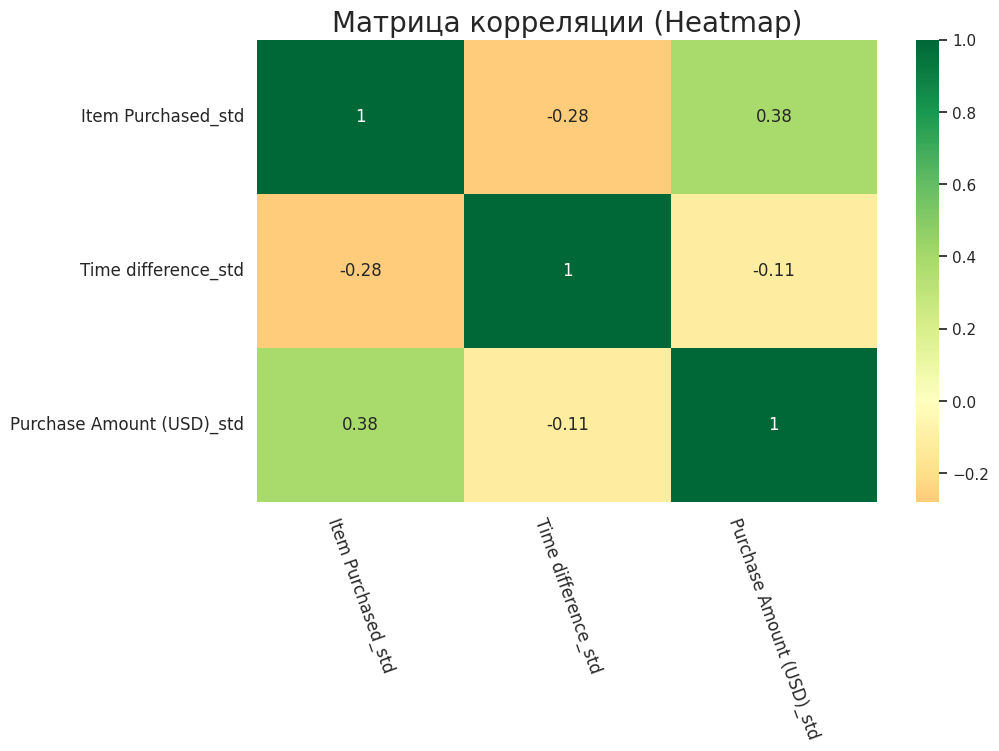

In [19]:
# Матрица корреляции
correlation_matrix = rfm_std_df.corr()
print("Матрица корреляции:")
print(correlation_matrix)

# Построение heatmap для матрицы корреляции
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_std_df.corr(), xticklabels = rfm_std_df.corr().columns,
            yticklabels = rfm_std_df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Матрица корреляции (Heatmap)', fontsize=20)
plt.xticks(fontsize=12, rotation=-70)
plt.yticks(fontsize=12)
plt.show()

In [22]:
rfm_std_df.drop(columns=['Customer Reference ID'], inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(rfm_std_df.corr(), xticklabels=rfm_std_df.corr().columns,
            yticklabels=rfm_std_df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Матрица корреляции (Heatmap)', fontsize=20)
plt.xticks(fontsize=12, rotation=-70)
plt.yticks(fontsize=12)
plt.show()

KeyError: "['Customer Reference ID'] not found in axis"

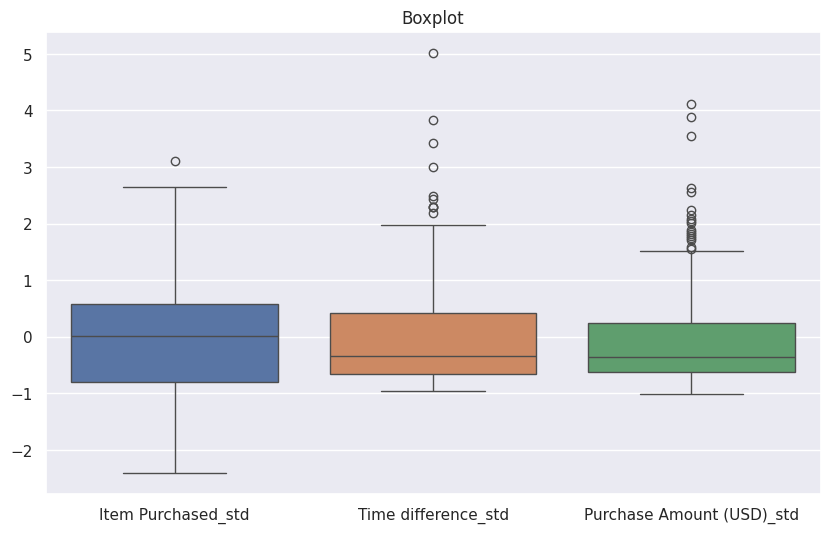

In [34]:
# Матрица выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm_std_df[['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']])
plt.title('Boxplot')
plt.show()

Можем заметить, что выбросов достаточно много, но некоторые едлиничные отклонения сильно отличаются от других, сдедовательно от них можно избавиться ❗  :

 Z-оценка - это количество стандартных отклонений. Все значения, находящиеся за пределами этого диапазона, будут считаться выбросами и удаляться из данных.

In [24]:
# from scipy import stats

# # Функция для удаления выбросов
# def remove_outliers_zscore(df, threshold=3):
#     return df[(np.abs(stats.zscore(df)) < threshold).all(axis=1)]

# df_cleaned = remove_outliers_zscore(df[['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']])


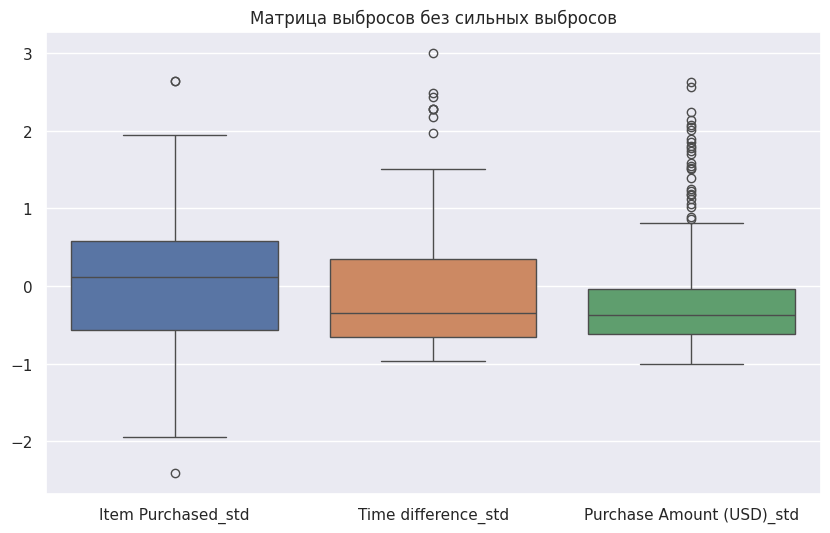

In [25]:
def remove_outliers(df, columns, z_thresh=3):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std() # стандартное отклонение
        # z_thresh - коэффициент, который определяет, сколько стандартных отклонений от среднего значения нужно взять для фильтрации.
        df = df[(df[col] >= mean - z_thresh * std) & (df[col] <= mean + z_thresh * std)]
    return df

# Колонки, из которых убираем выбросы
cols_to_check = ['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']
rfm_std_ = remove_outliers(rfm_std_df, cols_to_check)

# Матрица выбросов без ЖЕСТКИХ выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm_std_[cols_to_check])
plt.title('Матрица выбросов без сильных выбросов')
plt.show()

Теперь некоторое значение аномальных выбросов было удалено, а значит модель работает лучше)

--------------------------------------------------------

Реализация алгоритма ***k-means***.

📜 Покажем процесс подбора оптимального числа кластеров с визуализацией всех графиков 📜

In [65]:
# Создание списка для хранения значений инерции
inertia = []

# рассчитываем инерцию для каждого
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_std_[['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']])
    inertia.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Определим максимально логичное количество кластеров с помощью метода локтя

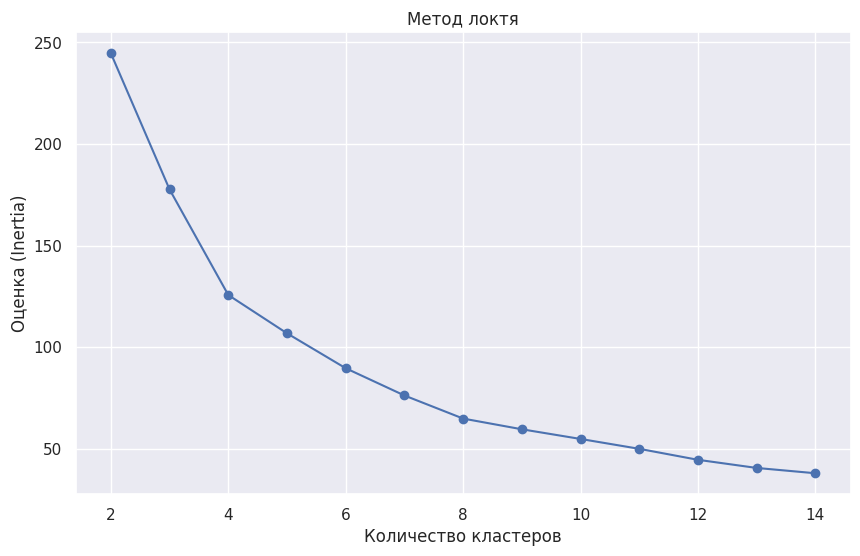

In [66]:
# Построение графика метода "Elbow"
plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Оценка (Inertia)')
plt.title('Метод локтя')
plt.grid(True)
plt.show()

По данной диаграмме мы видим, что оптимальное количество кластеров будет равно 4...

Создание диаграммы рассеяния для данных

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4, The average silhouette_score is : 0.35878675398737264


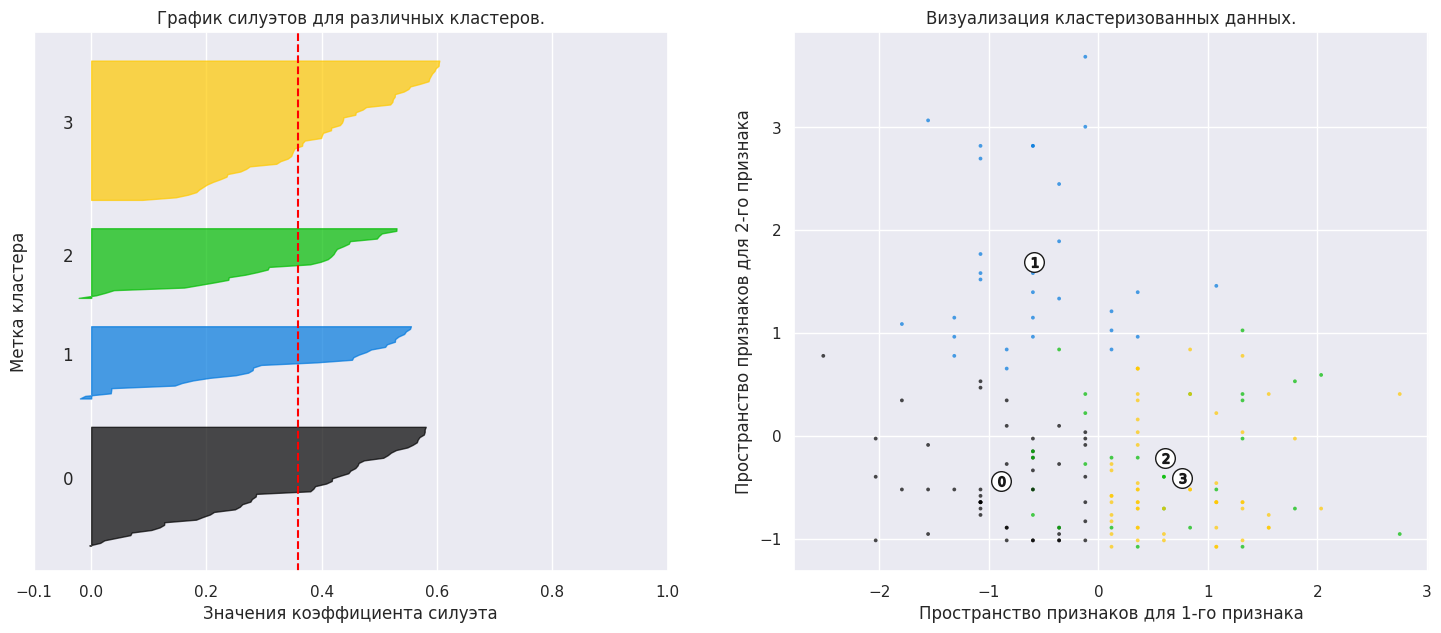

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5, The average silhouette_score is : 0.3601005871831813


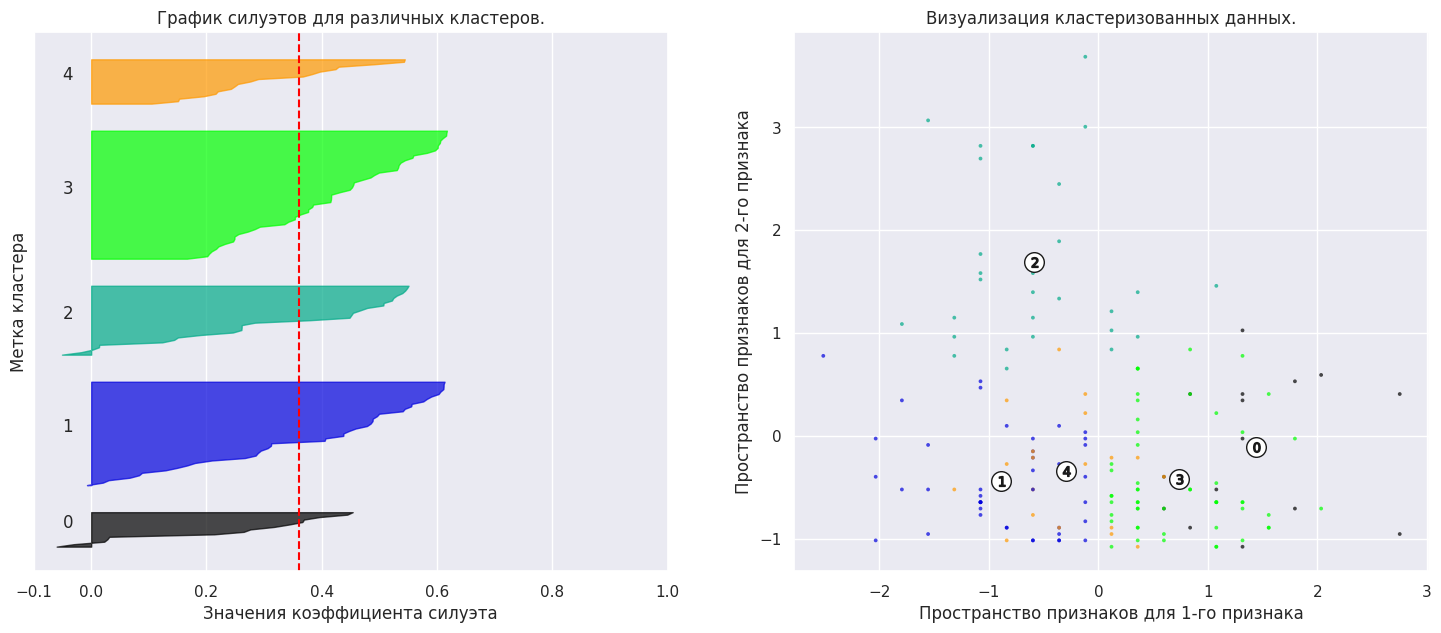

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6, The average silhouette_score is : 0.3616083984939525


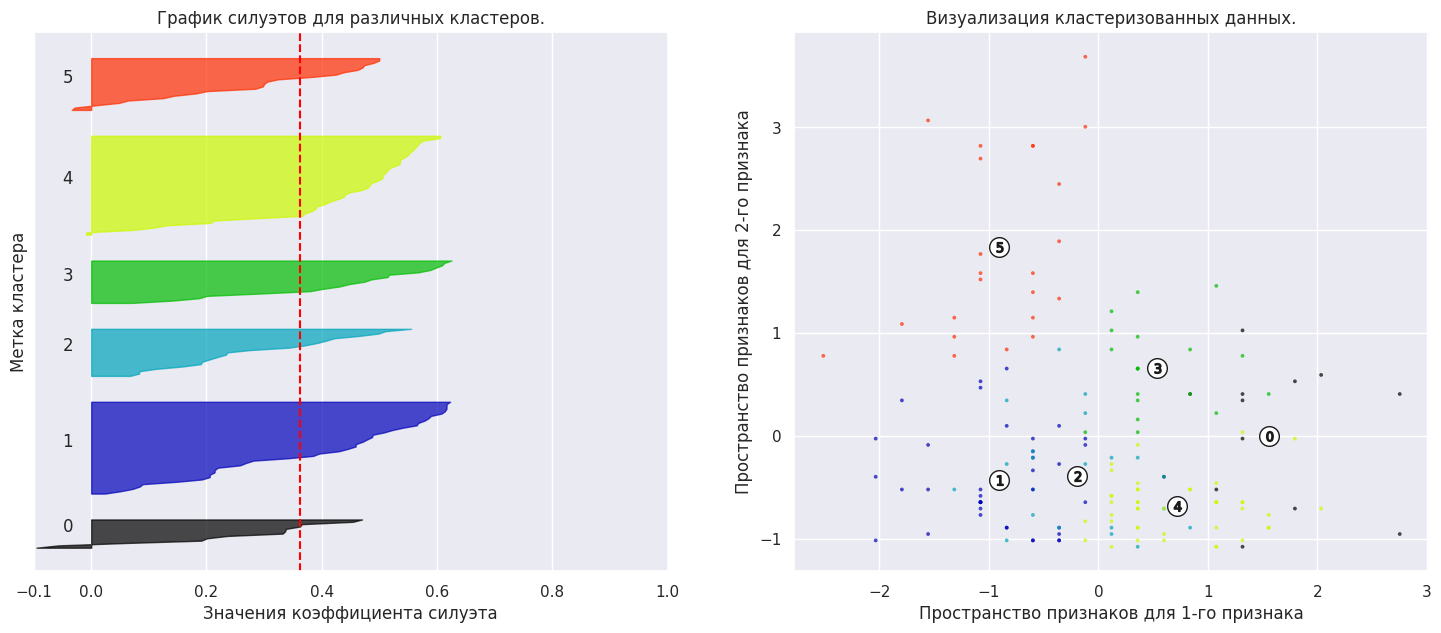

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7, The average silhouette_score is : 0.3437164819029168


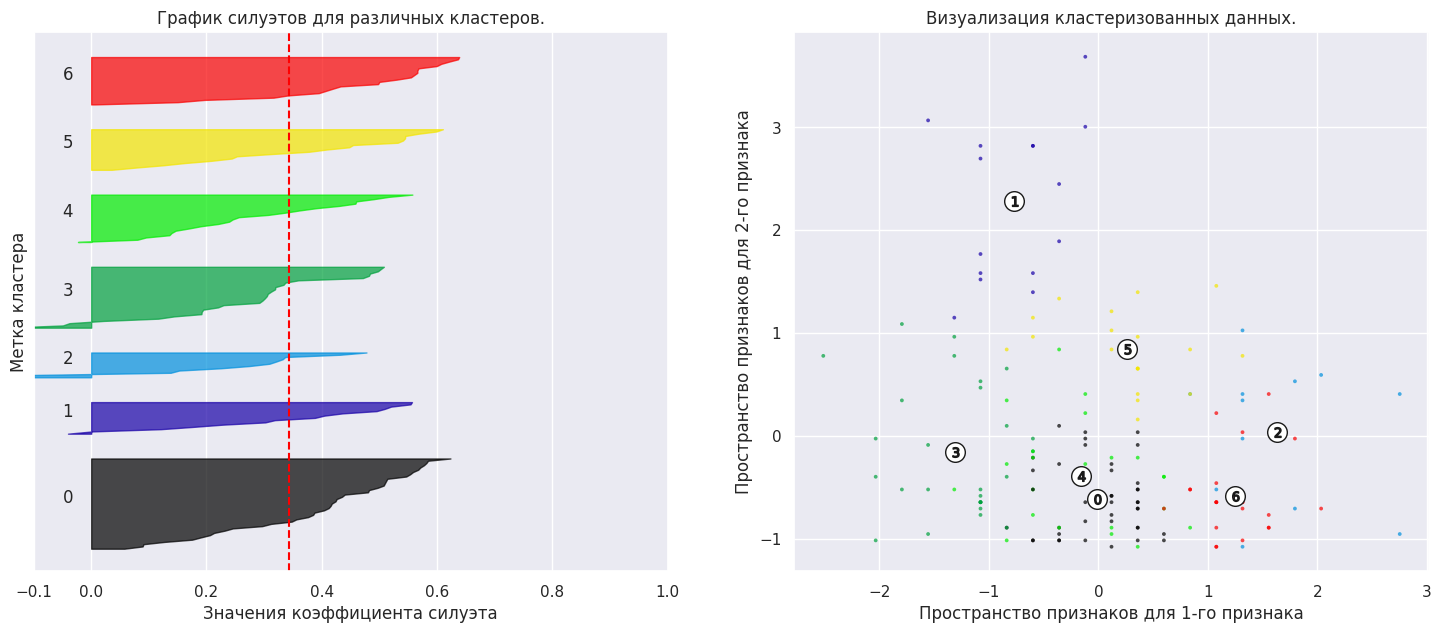

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8, The average silhouette_score is : 0.3672128662045975


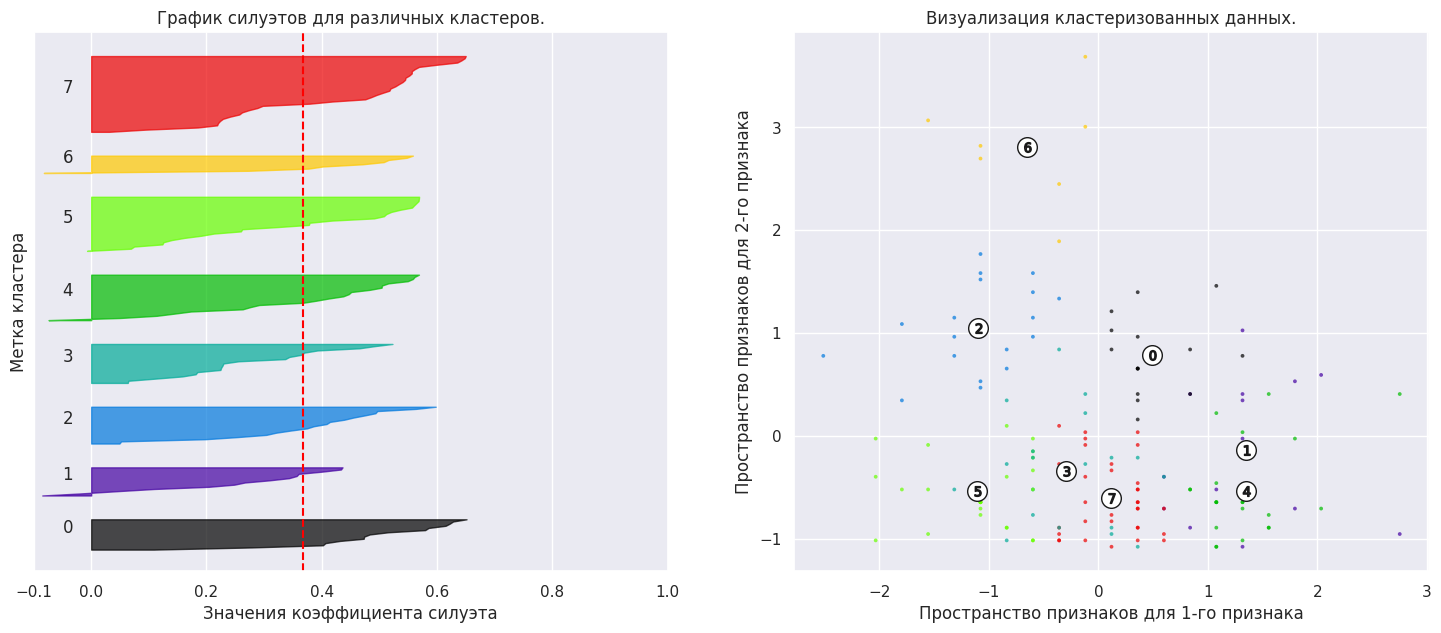

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9, The average silhouette_score is : 0.3677571830632144


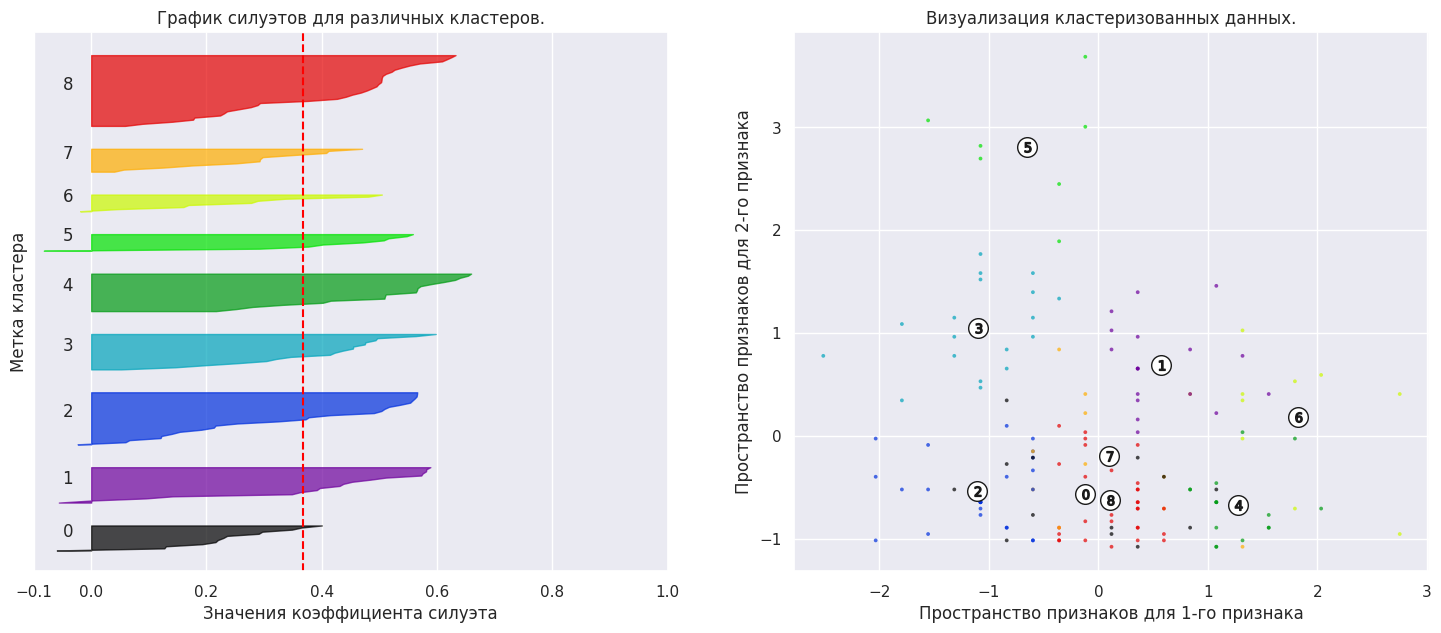

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10, The average silhouette_score is : 0.3754006982727298


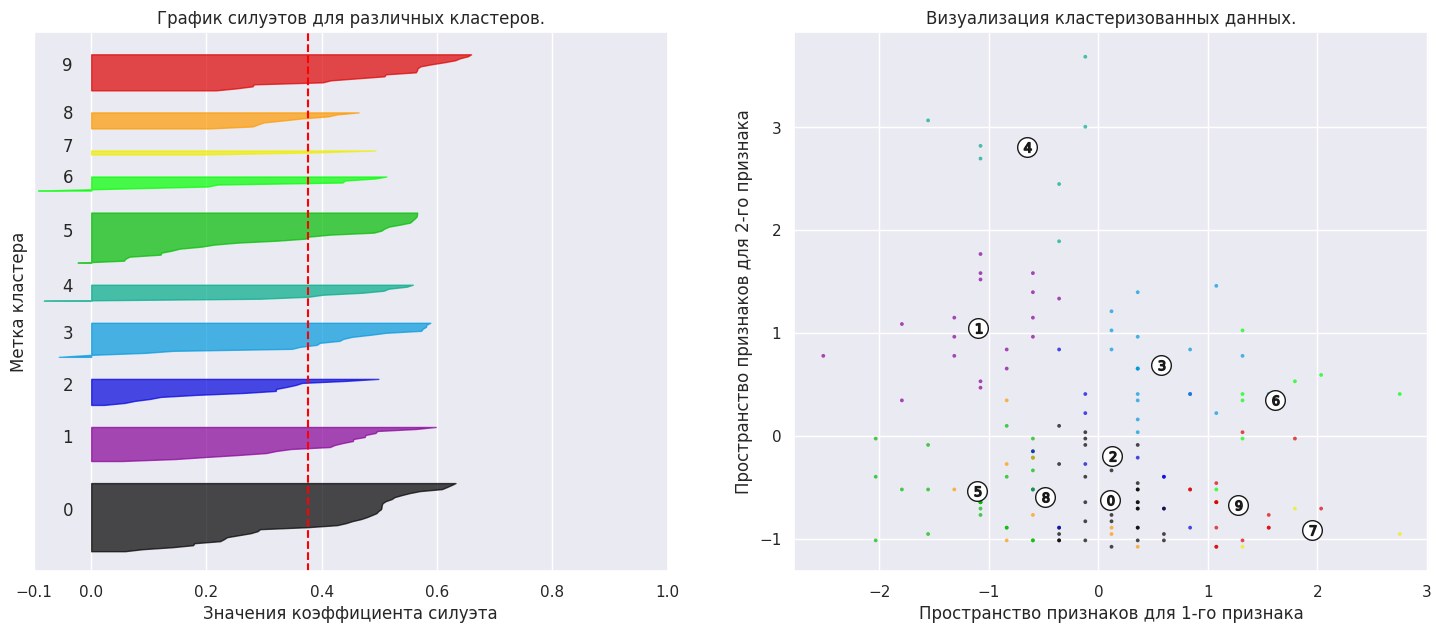

In [64]:
# Подготовим данные
cols_to_check = ['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']

# Убедимся, что данные стандартизированы
scaler = StandardScaler()
X = scaler.fit_transform(rfm_std_[cols_to_check])

range_n_clusters = [4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # График силуэтов. Устанавливаются пределы для осей графика силуэтов
  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(X)
  # Метод fit_predict одновременно обучает модель и возвращает метки кластеров (cluster_labels) для каждого образца данных.


  silhouette_avg = silhouette_score(X, cluster_labels) # вычисляет среднее значение силуэта для всех образцов
  print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg}")

  # Вычисление индивидуальных значений силуэтов
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
      # Из всех силуэтных значений выбираются только те, которые принадлежат текущему кластеру
      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      # кол точек данных в этом кластере
      y_upper = y_lower + size_cluster_i # Рассчитывается верхняя граница

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
      # Цвет выбирается пропорционально номеру кластера
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  ax1.set_title("График силуэтов для различных кластеров.")
  ax1.set_xlabel("Значения коэффициента силуэта")
  ax1.set_ylabel("Метка кластера")

  # Визуализация данных кластеров
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  # Добавляется вертикальная пунктирная линия

  ax1.set_yticks([])
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  # Нормализуем метки кластеров путем деления на общее количество кластеров n_clusters. Это необходимо, чтобы создать массив значений в диапазоне 0-1
  # который потом используется для получения цветов.
  ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

  centers = clusterer.cluster_centers_

  ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
  # Отображаются центры кластеров в виде белых кругов с чёрной окантовкой.

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

  ax2.set_title("Визуализация кластеризованных данных.")
  ax2.set_xlabel("Пространство признаков для 1-го признака")
  ax2.set_ylabel("Пространство признаков для 2-го признака")

  plt.show()

1.   График "Silhouette Plot for the Various Clusters" (Силуэтные диаграммы)

Силуэтный коэффициент измеряет как близко каждый объект в кластере находится к объектам из соседних кластеров. Значение изменяется от -1 до 1. Чем ближе коэффициент к 1, тем лучше объект соответствует своему кластеру и тем дальше он от соседних кластеров.

*   Средний силуэтный коэффициент для всех кластеров ~0.37
*   Кластеры 2 (зеленый) и 1 (голубой) имеют низкие силуэтные коэффициенты по сравнению с кластерами 3 и 0 (желтый и черный)

2.   График "The Visualization of the Clustered Data" (Визуализация данных кластеров)

Кластеры 1 и 0 лучше разделены в пространстве признаков, что коррелирует с более высокими силуэтными коэффициентами для этих кластеров.

Некоторая степень перекрытия между кластерами 0 и 1, что может объяснять их низкие силуэтные коэффициенты

✅ Создадим интерактивную визуализацию процесса кластеризации 𝐾-Means ✅

interactive(children=(IntSlider(value=0, description='frame', max=50), IntSlider(value=8, description='n_clust…

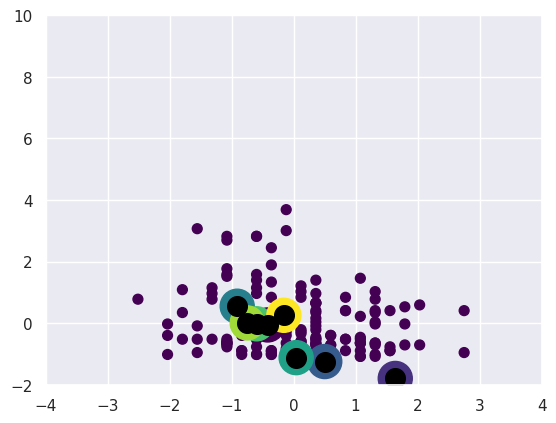

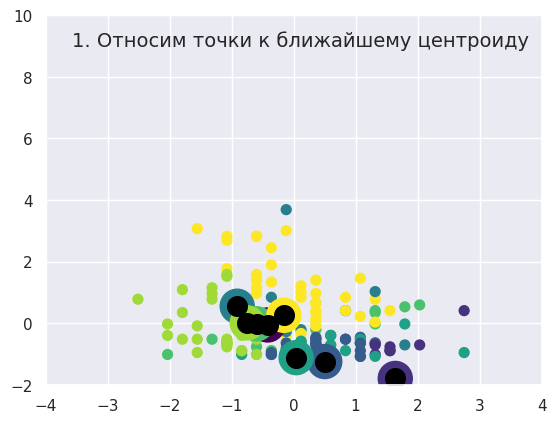

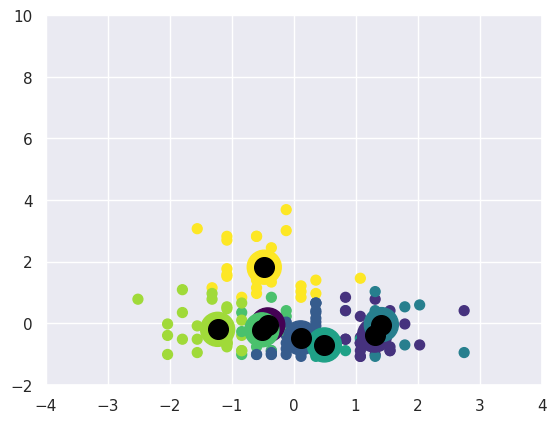

In [52]:
def plot_kmeans_interactive(min_clusters=1, max_clusters=8):
    # Подготовим данные
    cols_to_check = ['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']

    # Убедимся, что данные стандартизированы
    scaler = StandardScaler()
    X = scaler.fit_transform(rfm_std_[cols_to_check])

    def plot_points(X, labels, n_clusters):
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', vmin=0, vmax=n_clusters - 1)

    def plot_centers(centers):
        plt.scatter(centers[:, 0], centers[:, 1], marker='o', c=np.arange(centers.shape[0]), s=600, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], marker='o', c='black', s=200)

    def _kmeans_step(frame=0, n_clusters=8):
        rng = np.random.RandomState(2)
        # labels: Обновление меток кластеров для каждого шага.
        #centers: Обновление координат центров кластеров.
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, X.shape[1])

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                labels = pairwise_distances_argmin(X, centers)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0) for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]

        plot_points(X, labels, n_clusters)
        plot_centers(old_centers)

        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i], arrowprops=dict(arrowstyle='->', linewidth=1))
            plot_centers(centers)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "1. Относим точки к ближайшему центроиду", ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "2. Меняем центроид на среднее", ha='right', va='top', size=14)

    return interactive(_kmeans_step, frame=(0, 50), n_clusters=(min_clusters, max_clusters))

interactive_plot = plot_kmeans_interactive()
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [67]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(rfm_std_)
Y_pred = kmeans.labels_

print("Метки кластеров, вычисленные алгоритмом KMeans:")
print(Y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Метки кластеров, вычисленные алгоритмом KMeans:
[6 7 4 7 6 6 6 4 4 6 0 8 0 1 5 9 2 8 3 4 0 7 2 3 6 4 3 0 2 7 0 6 7 4 0 6 0
 6 1 3 6 6 0 2 9 6 4 6 0 1 0 6 9 4 3 1 8 4 4 2 3 4 4 4 1 7 1 4 1 4 7 0 5 7
 4 7 9 3 4 6 5 5 4 7 6 1 8 1 7 6 5 0 6 1 3 3 6 6 4 6 3 5 6 0 4 0 4 3 9 5 9
 1 6 0 0 9 7 8 3 2 0 9 7 1 7 8 6 1 6 1 1 0 1 6 8 6 3 6 8 9 2 4 0 7 5 2 2 0
 8 6 4 2 4 0 6 4 4 5 9]


Метки кластеров (labels), которые вычисляет алгоритм KMeans, обозначают принадлежность каждого объекта из набора данных к конкретному кластеру.

-----------------------------------------------------------------

In [32]:
# scaler = StandardScaler()
# X = scaler.fit_transform(rfm_std_df[['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']])

# # Выполним кластеризацию KMeans с числом кластеров 4
# kmeans = KMeans(n_clusters=4, random_state=0)
# rfm_std_df['cluster'] = kmeans.fit_predict(X)

# # Визуализируем результаты кластеризации
# plt.figure(figsize=(10, 7))

# # Отображаем точки для каждого кластера
# plt.plot(rfm_std_df[rfm_std_df['cluster'] == 0]['Item Purchased_std'], rfm_std_df[rfm_std_df['cluster'] == 0]['Purchase Amount (USD)_std'], 'bo', label='class1')
# plt.plot(rfm_std_df[rfm_std_df['cluster'] == 1]['Item Purchased_std'], rfm_std_df[rfm_std_df['cluster'] == 1]['Purchase Amount (USD)_std'], 'go', label='class2')
# plt.plot(rfm_std_df[rfm_std_df['cluster'] == 2]['Item Purchased_std'], rfm_std_df[rfm_std_df['cluster'] == 2]['Purchase Amount (USD)_std'], 'ro', label='class3')
# plt.plot(rfm_std_df[rfm_std_df['cluster'] == 3]['Item Purchased_std'], rfm_std_df[rfm_std_df['cluster'] == 3]['Purchase Amount (USD)_std'], 'yo', label='class4')

# plt.xlabel('Item Purchased_std')
# plt.ylabel('Purchase Amount (USD)_std')
# plt.legend(loc=0)
# plt.title('Кластеризация KMeans')
# plt.show()

---------------------------------------------------------------------------


# ***Иерархическая кластеризация*** 📊

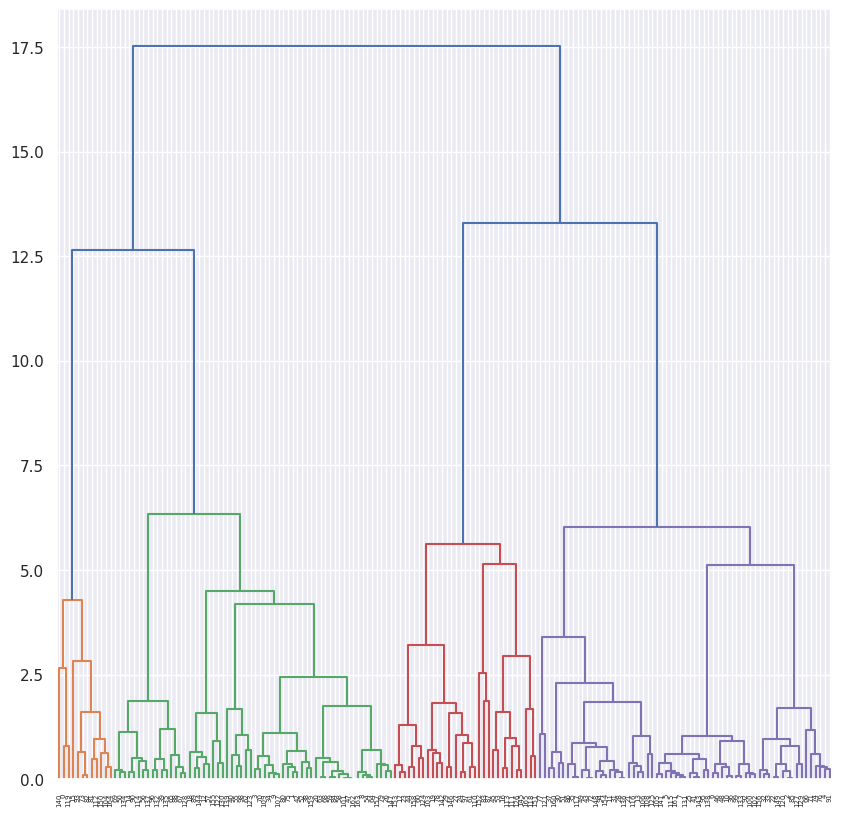

[1 2 3 4]
     Item Purchased_std  Time difference_std  Purchase Amount (USD)_std  \
0             -1.485774             3.421323                  -0.861438   
1             -0.110466            -0.089257                  -0.758967   
2              0.347969             0.478631                  -0.361890   
3             -0.568902            -0.089257                  -0.703276   
4              0.347969             0.736762                  -0.370801   
..                  ...                  ...                        ...   
161            0.347969            -0.605519                  -0.444313   
162           -1.027338            -0.605519                  -0.746158   
163           -0.339684            -0.915276                  -0.465476   
164           -0.568902             2.285547                  -0.491093   
165            2.640149            -0.863650                   1.707028   

     payment_type  pred_sklearn  
0               1             0  
1               2    

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


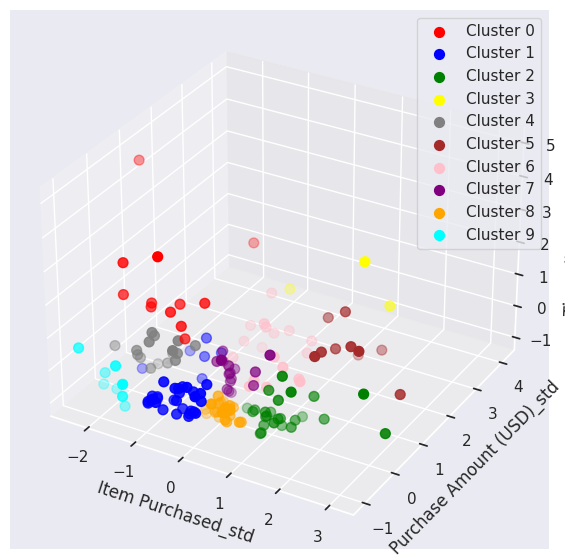

In [74]:
Z = linkage(rfm_std_df[['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']], method='ward')

fig = plt.figure(figsize=(10, 10))
dn = dendrogram(Z)
plt.show()

# Используем метод fcluster для определения кластеров
y_pred = fcluster(Z, 10, criterion='distance')
print(np.unique(y_pred))

# Добавляем кластерные метки в DataFrame
rfm_std_df['payment_type'] = y_pred
print(rfm_std_df)

# Кластеризация с использованием AgglomerativeClustering от sklearn
hc = AgglomerativeClustering(n_clusters = 10, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(rfm_std_df[['Item Purchased_std', 'Time difference_std', 'Purchase Amount (USD)_std']])

# Добавляем результат кластеризации в DataFrame
rfm_std_df['pred_sklearn'] = y_hc
print(rfm_std_df)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green', 'yellow', 'grey', 'brown', 'pink', 'purple', 'orange', 'cyan']
labels = range(1, 11)

for color, label in zip(colors, np.unique(y_hc)):
    ax.scatter(rfm_std_df.loc[y_hc == label, 'Item Purchased_std'],
               rfm_std_df.loc[y_hc == label, 'Purchase Amount (USD)_std'],
               rfm_std_df.loc[y_hc == label, 'Time difference_std'],
               s=50, color=color, label=f'Cluster {label}')

ax.set_xlabel('Item Purchased_std')
ax.set_ylabel('Purchase Amount (USD)_std')
ax.set_zlabel('Time difference_std')
ax.legend()
plt.show()


# **Дедрограмма**

Ось Y представляет собой расстояние (или различие) между кластерами. Чем выше место соединения на оси Y, тем далее кластеры расположены друг от друга

Ось X представляет индивидуальные объекты или группы объектов.

Чтобы определить количество кластеров, проведем горизонтальную линию на уровне, где удаление от псевдочленов кластера максимальное и значимое. В данном случае, можно определить четыре основных кластера (синий, зеленый, красный и фиолетовый).

Высота, на которой происходит объединение кластеров, говорит о различиях внутри данных. Чем выше объединение, тем более различны кластеры.
Объединенные низко кластеры имеют более высокую схожесть между собой. Таким образом, тут видим, что синий кластер более различные данные от остальных признаков